# Influenza

In [4]:
import numpy as np
from scipy.integrate import odeint
import random
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_excel('influenza.xlsx')
df

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Year,Epidemiological week,Influenza
0,2003,1,0
1,2003,2,0
2,2003,3,0
3,2003,4,0
4,2003,5,2
...,...,...,...
359,2009,48,8
360,2009,49,10
361,2009,50,2
362,2009,51,4


In [6]:
# Convertir a array de NumPy
influenza_data = np.array(df['Influenza'])
len(influenza_data)

364

In [ ]:
# Definir el modelo SEIRS individual
def modelo(y, t, beta, gamma, eta, mu, theta, N):
    S, E, I, R = y
    dSdt = mu * N - (beta * S * I / N) - mu * S + theta * R
    dEdt = (beta * S * I / N) - (mu + gamma) * E
    dIdt = gamma * E - (mu + eta) * I
    dRdt = eta * I - (mu + theta) * R
    return [dSdt, dEdt, dIdt, dRdt]

# Función para simular el modelo en el tiempo
def sim_modelo(params, S0, E0, I0, R0, N, time):
    beta, gamma, eta, mu, theta = params
    y0 = [S0, E0, I0, R0]
    ret = odeint(modelo, y0, time, args=(beta, gamma, eta, mu, theta, N))
    S, E, I, R = ret.T
    return I  # Retornamos los infectados

# Función de verosimilitud
def likelihood(data, predicted_cases):
    # Truncar las predicciones a 364 días (52 semanas)
    predicted_cases = predicted_cases[:364]
    predicted_weekly = predicted_cases.reshape(-1, 7).sum(axis=1)  # Sumar cada 7 días
    
    # Calcular la verosimilitud
    sigma = np.std(data)
    log_likelihood = -0.5 * np.sum((data - predicted_weekly)**2 / sigma**2)
    return log_likelihood

# MCMC
def mcmc(data, param_0, iter, time, S0, E0, I0, R0, N):
    # Parámetros iniciales
    beta, gamma, eta, mu, theta = param_0
    accepted_params = []
    current_likelihood = likelihood(data, sim_modelo(param_0, S0, E0, I0, R0, N, time))
    
    for i in range(iter):
        # Proponer nuevos parámetros
        new_params = [
            beta + random.uniform(-0.01, 0.01),
            gamma + random.uniform(-0.01, 0.01),
            eta + random.uniform(-0.01, 0.01),
            mu + random.uniform(-0.001, 0.001),
            theta + random.uniform(-0.01, 0.01)
        ]
        
        # Simular el modelo con los nuevos parámetros
        new_predicted = sim_modelo(new_params, S0, E0, I0, R0, N, time)
        
        # Calcular la nueva verosimilitud
        new_likelihood = likelihood(data, new_predicted)
        
        # Probabilidad de aceptación
        accept_prob = np.exp(new_likelihood - current_likelihood)
        
        if accept_prob > random.uniform(0, 1):
            # Aceptar nuevos parámetros
            beta, gamma, eta, mu, theta = new_params
            current_likelihood = new_likelihood
            accepted_params.append(new_params)
    
    return accepted_params

In [8]:
# Parámetros iniciales
param_0 = [0.5, 0.2, 0.1, 0.01, 0.01]  # beta, gamma, eta, mu, theta

# Condiciones iniciales
N = 1000000  # Población total
S0 = N - 1   # Susceptibles iniciales
E0, I0, R0 = 0, 1, 0  # Expuestos, infectados y recuperados iniciales

# Tiempo de simulación (diario)
time = np.arange(0, 364, 1)  # 52 semanas (364 días)

# Ejecutar MCMC
accepted_params = mcmc(influenza_data, param_0, iter=10000, time=time, S0=S0, E0=E0, I0=I0, R0=R0, N=N)

# Convertir los parámetros aceptados a un array de NumPy
accepted_params = np.array(accepted_params)

ValueError: operands could not be broadcast together with shapes (364,) (52,) 

NameError: name 'accepted_params' is not defined

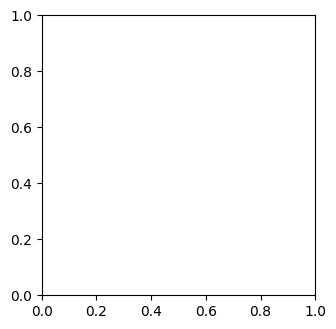

In [9]:
# Graficar las distribuciones posteriores de los parámetros
plt.figure(figsize=(12, 8))
param_names = ['beta', 'gamma', 'eta', 'mu', 'theta']
for i in range(5):
    plt.subplot(2, 3, i+1)
    plt.hist(accepted_params[:, i], bins=30, color='blue', alpha=0.7)
    plt.title(f'Distribución de {param_names[i]}')
plt.tight_layout()
plt.show()

# Validación del modelo
best_params = accepted_params[-1]  # Usar los últimos parámetros aceptados
predicted = sim_modelo(best_params, S0, E0, I0, R0, N, time)

# Truncar las predicciones a 52 semanas
predicted_weekly = predicted[:364].reshape(-1, 7).sum(axis=1)

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(influenza_data, 'ro', label='Datos observados de influenza')
plt.plot(predicted_weekly, 'b-', label='Predicciones del modelo')
plt.xlabel('Semanas')
plt.ylabel('Casos de influenza')
plt.legend()
plt.show()

# Calcular el Error Cuadrático Medio (MSE)
mse = np.mean((influenza_data - predicted_weekly)**2)
print(f'MSE: {mse}')

# Calcular el Coeficiente de Determinación (R²)
def r_squared(observed, predicted):
    mean_observed = np.mean(observed)
    ss_total = np.sum((observed - mean_observed)**2)
    ss_residual = np.sum((observed - predicted)**2)
    return 1 - (ss_residual / ss_total)

r2 = r_squared(influenza_data, predicted_weekly)
print(f'R²: {r2}')